# Convergencia Tipo X

In [20]:
import numpy as np
import pandas as pd

import sys, os

from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
import sys, os; sys.path.append(os.path.dirname(os.getcwd()))
from pyfrechet.metric_spaces import MetricData, LogCholesky, spd_to_log_chol, log_chol_to_spd
from pyfrechet.regression.bagged_regressor import BaggedRegressor
from pyfrechet.regression.trees import Tree
from sklearn.model_selection import train_test_split
from pyfrechet.metric_spaces import MetricData, LogEuclidean, CustomAffineInvariant, CustomLogEuclidean, AffineInvariant, LogCholesky, log_chol_to_spd, spd_to_log_chol

from typing import Union

from scipy.special import digamma

from scipy.stats import wishart

## Functions

In [21]:
def generate_random_spd_matrix(q_array, limits_unif = 30, seed = 1):
    """Generate a random q x q symmetric positive definite (SPD) matrix."""
    np.random.RandomState(seed)
    
    q_array = np.array(q_array, dtype = int)
    # Ensure the matrices are symmetric positive definite
    mat = [(np.random.rand(q_array[i], q_array[i])-1/2)*limits_unif for i in range(len(q_array))]
    return [np.dot(mat[i], mat[i].T) for i in range(len(q_array))]

def Sigma_t(t_array, Sigma_array):
    """Provides an array with the matrices given by a regression model that interpolates between four matrices."""  
    """The regression starts with Sigma_1 and then goes to Sigma_2 and Sigma_3 and ends in Sigma_4."""
    
    # Define time intervals for interpolation
    t_array = np.array(t_array)
    t_array = t_array[:, None, None]

    # Return the interpolated matrices
    return np.where(t_array < 0.5, np.cos(np.pi*t_array)**2 * Sigma_array[0] + (1 - np.cos(np.pi*(1-t_array))**2) * Sigma_array[1], 0) + np.where(t_array >= 0.5, (1 - np.cos(np.pi*t_array)**2) * Sigma_array[1] + np.cos(np.pi*(1-t_array))**2 * Sigma_array[2], 0)


def sim_regression_matrices(Sigmas: tuple,
                            t: np.array,
                            df: int=2):
    t = np.array(t)
    
    #Simulate the time for regression (sample_t) and the true time (true_t)
    q = Sigmas[0].shape[0]

    c_dq = 2 * np.exp((1 / q) * sum( digamma((df - np.arange(1, q + 1) + 1 ) / 2) ))
    sigma_t = Sigma_t(t, Sigmas)
    sample_Y = [wishart( df=df, scale = sigma_t[k] / c_dq ).rvs( size=1 ) for k in range(t.shape[0])]
    return {'t': t, 'y': sample_Y}

def plot_ellipse(mat: np.ndarray, ax, 
                 xy: tuple=(0,0),
                 scale_factor=1,
                 edgecolor='red',
                 facecolor='None',
                 linewidth=2,
                 alpha=1):
    eigenvalues, eigenvectors = np.linalg.eig(mat)
    theta = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    ellipse = Ellipse(xy=xy,
                  width=scale_factor*np.sqrt(eigenvalues[0]),
                  height=scale_factor*np.sqrt(eigenvalues[1]),
                  angle=theta,
                  edgecolor=edgecolor,
                  facecolor=facecolor,
                  lw=linewidth,
                  alpha=alpha)
    ax.add_patch(ellipse)


def plot_OOB_balls_SPD( prediction: np.ndarray,
                        Ralpha: float,
                        ax,
                        alpha: float = 0.05,
                        reference: Union[np.ndarray, None]=None,
                        scale_factor: float=1/10,
                        xy_factor: float=50,
                        df: int=5,
                        MC_samples: int=100,
                        edge_color='deepskyblue',
                        dist : str = 'LC',
                        limits_unif : int = 30
                        ) -> None:
    if dist == 'LC':
        M = LogCholesky(dim = 2)
        if not reference is None:
            sample = generate_random_spd_matrix(q_array=np.repeat(2, MC_samples), limits_unif = limits_unif, seed=4)
            sample = [spd_to_log_chol(A) for A in sample]
            for A in sample:
                if M.d(A, prediction)<=Ralpha:
                    plot_ellipse(log_chol_to_spd(A), ax=ax, xy=(1/xy_factor,0), scale_factor=scale_factor, edgecolor=edge_color,
                                alpha=alpha)
                    

            plot_ellipse(log_chol_to_spd(prediction), ax=ax, 
                        xy=(1/xy_factor,0), scale_factor=scale_factor, edgecolor='black', alpha=1)

            plot_ellipse(log_chol_to_spd(reference), ax=ax, 
                        xy=(1/xy_factor,0), scale_factor=scale_factor, edgecolor='red', alpha=1)

        else:
            sample = generate_random_spd_matrix(q_array=np.repeat(df, MC_samples), limits_unif = limits_unif, seed=4)
            for A in sample:
                if M.d(A, prediction)<=Ralpha:

                    plot_ellipse(log_chol_to_spd(A), ax=ax, xy=(1/xy_factor,0), scale_factor=scale_factor, edgecolor=edge_color,
                                alpha=alpha)
                                

            plot_ellipse(log_chol_to_spd(prediction), ax=ax, 
                        xy=(1/xy_factor,0), scale_factor=scale_factor, edgecolor='black', alpha=1)
            

    elif dist == 'AI':
        M = CustomAffineInvariant(dim = 2)
        if not reference is None:
            sample = generate_random_spd_matrix(q_array=np.repeat(2, MC_samples), limits_unif = limits_unif, seed=4)
            for A in sample:
                if M.d(A, prediction)<=Ralpha:
                    plot_ellipse(A, ax=ax, xy=(1/xy_factor,0), scale_factor=scale_factor, edgecolor=edge_color,
                                alpha=alpha)
                    

            plot_ellipse(prediction, ax=ax, 
                        xy=(1/xy_factor,0), scale_factor=scale_factor, edgecolor='black', alpha=1)

            plot_ellipse(reference, ax=ax, 
                        xy=(1/xy_factor,0), scale_factor=scale_factor, edgecolor='red', alpha=1)

        else:
            sample = generate_random_spd_matrix(q_array=np.repeat(df, MC_samples), limits_unif = limits_unif, seed=4)

            for A in sample:
                if M.d(A, prediction)<=Ralpha:

                    plot_ellipse(A, ax=ax, xy=(1/xy_factor,0), scale_factor=scale_factor, edgecolor=edge_color,
                                alpha=alpha)
                                

            plot_ellipse(prediction, ax=ax, 
                        xy=(1/xy_factor,0), scale_factor=scale_factor, edgecolor='black', alpha=1)
    else:
        M = LogEuclidean(dim = 2)
        if not reference is None:
            sample = generate_random_spd_matrix(q_array=np.repeat(2, MC_samples), limits_unif = limits_unif, seed=4)
            for A in sample:

                if M.d(A, prediction)<=Ralpha:
                    plot_ellipse(A, ax=ax, xy=(1/xy_factor,0), scale_factor=scale_factor, edgecolor=edge_color,
                                alpha=alpha)
                    

            plot_ellipse(prediction, ax=ax, 
                        xy=(1/xy_factor,0), scale_factor=scale_factor, edgecolor='black', alpha=1)

            plot_ellipse(reference, ax=ax, 
                        xy=(1/xy_factor,0), scale_factor=scale_factor, edgecolor='red', alpha=1)

        else:
            sample = generate_random_spd_matrix(q_array=np.repeat(df, MC_samples), limits_unif = limits_unif, seed=4)
            for A in sample:
                if M.d(A, prediction)<=Ralpha:

                    plot_ellipse(A, ax=ax, xy=(1/xy_factor,0), scale_factor=scale_factor, edgecolor=edge_color,
                                alpha=alpha)
                                

            plot_ellipse(prediction, ax=ax, 
                        xy=(1/xy_factor,0), scale_factor=scale_factor, edgecolor='black', alpha=1)

In [22]:
dfs=[2, 2.5, 3, 3.5, 4, 5, 6]

# Obtain coverage results dataframe from the results files
def coverage_results(dfs: list, dist: str= 'LC') -> pd.DataFrame:
    coverage_df=pd.DataFrame(columns=['sample_index', 'train_size', 'df', 'y_train_data', 'train_predictions', 'OOB_quantile', 'OOB_errors', 'forest'])
    for file in os.listdir(os.path.join(os.getcwd(), 'results')):
        if file.endswith('.npy') and file.split('_')[0] == dist:
            infile=open(os.path.join(os.getcwd(), 'results/'+file), 'rb')
            result=np.load(infile, allow_pickle=True).item()
            infile.close()

            coverage_df=pd.concat([coverage_df, 
                                    pd.DataFrame({  'distance': dist,
                                                    'sample_index': int(file.split('_')[2][4:]),
                                                    'train_size': int(file.split('_')[3][1:]),
                                                    'df': dfs[int(file.split('_')[4][2:])-1],
                                                    'y_train_data': [result['y_train_data']],
                                                    'train_predictions': [result['train_predictions']],
                                                    'OOB_quantile': [result['OOB_quantile']],
                                                    'OOB_errors': [result['OOB_errors']], 
                                                    'forest': [result['forest']],
                                                }, index=pd.RangeIndex(0,1))],
                                    ignore_index=True)
        
    coverage_df['train_size'] = coverage_df['train_size'].astype('category')
    coverage_df['sample_index'] = coverage_df['sample_index'].astype('category')
    coverage_df['df'] = coverage_df.df.astype('category')

    return coverage_df

coverage_df_AI = coverage_results(dist = 'AI', dfs=dfs)
#coverage_df_LC = coverage_results(dist = 'LC', dfs=dfs)
#coverage_df_LE = coverage_results(dist = 'LE', dfs=dfs)

#coverage_df_combined = pd.concat([coverage_df_AI, coverage_df_LC, coverage_df_LE], ignore_index=True)
#print(coverage_df_AI.info())
#print(coverage_df_LC.info())
#print(coverage_df_LE.info())

In [23]:
coverage_df_AI['II_coverage'] = [[0, 0, 0] for _ in range(len(coverage_df_AI))]
# coverage_df_LC['II_coverage'] = [[0, 0, 0] for _ in range(len(coverage_df_LC))]
# coverage_df_LE['II_coverage'] = [[0, 0, 0] for _ in range(len(coverage_df_LE))]

M = CustomAffineInvariant(dim = 2)
MC = 1000
q = 2

# Define the matrices to interpolate
Sigma_1 = np.array([[1, -0.6],
                  [-0.6, 0.5]])
Sigma_2 = np.array([[1, 0],
                  [0, 1]])
Sigma_3 = np.array([[0.5, 0.4],
                  [0.4, 1]])

Sigmas = (Sigma_1, Sigma_2, Sigma_3)

#Calculate coverage for every dataset L_n (Type IV):
for i, ln in coverage_df_AI.iterrows():
        #Generate observations to estimate the probability
    df = ln['df']
    new_t = np.random.uniform(size = MC)
    new_y = sim_regression_matrices(Sigmas = (Sigma_1, Sigma_2, Sigma_3), 
                                           t = new_t,  
                                           df = df)
    new_y = MetricData(M, np.array(new_y['y']))

    new_pred = ln['forest'].predict_matrix(new_t.reshape(-1,1))

    coverage_df_AI.at[i, 'II_coverage'] = np.sum(M.d(new_pred, new_y).reshape(-1,1) <= np.tile(ln['OOB_quantile'], (MC, 1)), axis = 0) / MC

In [36]:
# coverage_df_combined_alpha_01 = coverage_df_combined.copy()
# coverage_df_combined_alpha_05 = coverage_df_combined.copy()
# coverage_df_combined_alpha_1 = coverage_df_combined.copy()
# 
# coverage_df_combined_alpha_01['coverage'] = coverage_df_combined['coverage'].apply(lambda x: x[0])
# coverage_df_combined_alpha_01['OOB_quantile'] = coverage_df_combined['OOB_quantile'].apply(lambda x: x[0])
# 
# coverage_df_combined_alpha_05['coverage'] = coverage_df_combined['coverage'].apply(lambda x: x[1])
# coverage_df_combined_alpha_05['OOB_quantile'] = coverage_df_combined['OOB_quantile'].apply(lambda x: x[1])
# 
# coverage_df_combined_alpha_1['coverage'] = coverage_df_combined['coverage'].apply(lambda x: x[2])
# coverage_df_combined_alpha_1['OOB_quantile'] = coverage_df_combined['OOB_quantile'].apply(lambda x: x[2])
# 
# coverage_df_combined_alpha_01.head()
# coverage_df_combined_alpha_05.head()
# coverage_df_combined_alpha_1.head()

## Only for AI

coverage_df_AI_alpha_01 = coverage_df_AI.copy()
coverage_df_AI_alpha_05 = coverage_df_AI.copy()
coverage_df_AI_alpha_1 = coverage_df_AI.copy()

coverage_df_AI_alpha_01['II_coverage'] = coverage_df_AI['II_coverage'].apply(lambda x: x[0])
coverage_df_AI_alpha_01['OOB_quantile'] = coverage_df_AI['OOB_quantile'].apply(lambda x: x[0])

coverage_df_AI_alpha_05['II_coverage'] = coverage_df_AI['II_coverage'].apply(lambda x: x[1])
coverage_df_AI_alpha_05['OOB_quantile'] = coverage_df_AI['OOB_quantile'].apply(lambda x: x[1])

coverage_df_AI_alpha_1['II_coverage'] = coverage_df_AI['II_coverage'].apply(lambda x: x[2])
coverage_df_AI_alpha_1['OOB_quantile'] = coverage_df_AI['OOB_quantile'].apply(lambda x: x[2])

coverage_df_AI_alpha_01.head()
coverage_df_AI_alpha_05.head()
coverage_df_AI_alpha_1.head()

,sample_index,train_size,df,y_train_data,train_predictions,OOB_quantile,OOB_errors,forest,distance,II_coverage
0,28,200,4.0,"[[[0.707781518926878, -0.4971697860860136], [-...","[[[0.7011254982352806, -0.3089626676246153], [...",2.464358,"[1.064342002232941, 3.1196939915243616, 1.3675...","BaggedRegressor(bootstrap_fraction=1, bootstra...",AI,0.891
1,96,200,2.5,"[[[0.6121261388981926, -0.47652233220746787], ...","[[[0.41441397487803033, -0.38851443684612247],...",3.839549,"[0.5303093444290375, 5.209683622898844, 3.0151...","BaggedRegressor(bootstrap_fraction=1, bootstra...",AI,0.893
2,92,100,3.5,"[[[1.6479524266512429, -1.3234003757953778], [...","[[[0.9696744482391502, -0.7206051146196782], [...",2.732943,"[3.8349430476144675, 2.5739295258481674, 1.133...","BaggedRegressor(bootstrap_fraction=1, bootstra...",AI,0.898
3,24,500,4.0,"[[[0.33289335796342856, -0.4873700023986378], ...","[[[0.8228140157805839, -0.6736220931682263], [...",2.457600,"[2.791033020615907, 1.9739617699421272, 0.5825...","BaggedRegressor(bootstrap_fraction=1, bootstra...",AI,0.904
4,96,50,5.0,"[[[0.34750051986886765, -0.3054569897398389], ...","[[[0.7421963826386244, -0.49017641105175797], ...",2.034701,"[1.8190501364678822, 1.7070573044093431, 1.507...","BaggedRegressor(bootstrap_fraction=1, bootstra...",AI,0.911


# Boxplots

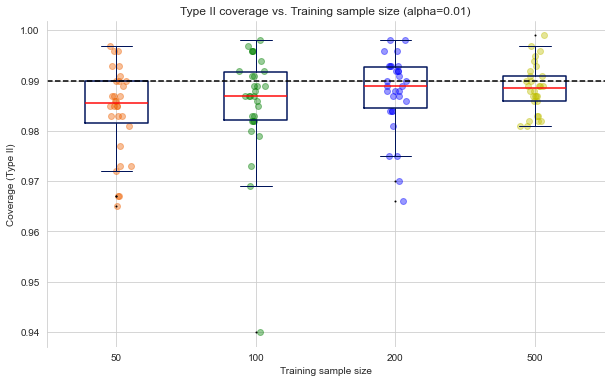

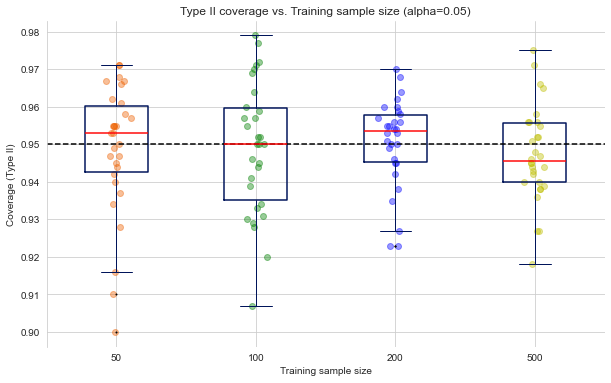

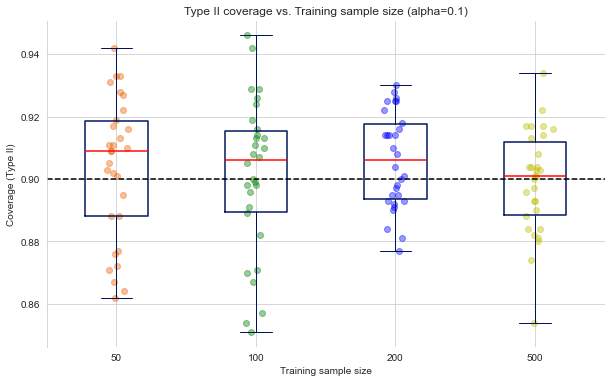

In [37]:
# Plot coverages vs. training sample size
# sns.set_style("whitegrid")
# 
# for data, alpha_level in zip([coverage_df_combined_alpha_01, coverage_df_combined_alpha_05, coverage_df_combined_alpha_1], [0.01, 0.05, 0.1]):
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(data = data, x='train_size', y='coverage', hue='distance', palette=sns.color_palette()[0:3],
#                 flierprops={"marker": "x"}, dodge=True, showmeans=True, meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'white','markersize':'4'})
#     
#     plt.legend(title='Distance')
#     plt.title(f'Coverages vs. Training sample size (alpha={alpha_level})')
#     plt.xlabel('Training sample size')
#     plt.ylabel('Coverage')
#     plt.axhline(y=1-alpha_level, color='black', linestyle='dashed')
#     plt.show()


# Only for AI

##### Set style options here #####
sns.set_style("whitegrid")  # "white","dark","darkgrid","ticks"
boxprops = dict(linestyle='-', linewidth=1.5, color='#00145A')
flierprops = dict(marker='o', markersize=1,
                  linestyle='none')
whiskerprops = dict(color='#00145A')
capprops = dict(color='#00145A')
medianprops = dict(linewidth=1.5, linestyle='-', color='#ff0808')

for data, alpha_level in zip([coverage_df_AI_alpha_01, coverage_df_AI_alpha_05, coverage_df_AI_alpha_1], [0.01, 0.05, 0.1]):
    plt.figure(figsize=(10, 6))

    #Note: when simulations are finalized, tehre should not be any need to select the first 40 (it is done because colukn had different lengths)
    data_50 = data[data['train_size'] == 50].iloc[0:30]
    data_100 = data[data['train_size'] == 100].iloc[0:30]
    data_200 = data[data['train_size'] == 200].iloc[0:30]
    data_500 = data[data['train_size'] == 500].iloc[0:30]

    boxplot_data = pd.DataFrame({
        '50': data_50['II_coverage'].values,
        '100': data_100['II_coverage'].values,
        '200': data_200['II_coverage'].values,
        '500': data_500['II_coverage'].values
    })

    #sns.boxplot(data = data, x='train_size', y='II_coverage',
               # flierprops={"marker": "x"}, dodge=True, showmeans=True, meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'white','markersize':'4'})
    plt.boxplot(boxplot_data, labels = ['50', '100', '200', '500'], notch=False, boxprops=boxprops, whiskerprops=whiskerprops,capprops=capprops, flierprops=flierprops, medianprops=medianprops,showmeans=False) 
    vals, names, xs = [],[],[]
    for i, col in enumerate(boxplot_data.columns):
        vals.append(boxplot_data[col].values)
        names.append(col)
        xs.append(np.random.normal(i + 1, 0.04, boxplot_data[col].values.shape[0]))  # adds jitter to the data points - can be adjusted
    palette = ['#ee6100', 'g', 'b', 'y']
    for x, val, c in zip(xs, vals, palette):
        plt.scatter(x, val, alpha=0.4, color=c)
    sns.despine(bottom=True) # removes right and top axis lines

    #plt.legend(bbox_to_anchor=(0.31, 1.06), loc=2, borderaxespad=0., framealpha=1, facecolor ='white', frameon=True)
    plt.title(f'Type II coverage vs. Training sample size (alpha={alpha_level})')
    plt.xlabel('Training sample size')
    plt.ylabel('Coverage (Type II)')
    plt.axhline(y=1-alpha_level, color='black', linestyle='dashed')
    plt.show()

In [27]:
#for data, alpha_level in zip([coverage_df_combined_alpha_01, coverage_df_combined_alpha_05, coverage_df_combined_alpha_1], [0.01, 0.05, 0.1]):   
#    if alpha_level == 0.01:
#        coverage_df = coverage_df_combined_alpha_01
#    elif alpha_level == 0.05:
#        coverage_df = coverage_df_combined_alpha_05
#    else:
#        coverage_df = coverage_df_combined_alpha_1
#
#    coverage_df_LC = coverage_df[coverage_df['distance'] == 'LC']
#    coverage_df_AI = coverage_df[coverage_df['distance'] == 'AI']
#    coverage_df_LE = coverage_df[coverage_df['distance'] == 'LE']
#    
#    plt.figure(figsize=(7,5))
#    sns.boxplot(data=coverage_df_LC, x='df', y='coverage', hue='train_size', palette=sns.color_palette()[0:4],
#                flierprops={'marker':'x'}, dodge=True)
#    plt.title(f'Coverages vs. Degrees of freedom, LC distance, $\\alpha=${alpha_level}')
#    plt.axhline(y=1-alpha_level, color='black', linestyle='dashed')
#    plt.legend()
#    plt.show()
#
#    plt.figure(figsize=(7,5))
#    sns.boxplot(data=coverage_df_AI, x='df', y='coverage', hue='train_size', palette=sns.color_palette()[0:4],
#                flierprops={'marker':'x'}, dodge=True)
#    plt.title(f'Coverages vs. Degrees of freedom, AI distance, $\\alpha=${alpha_level}')
#    plt.axhline(y=1-alpha_level, color='black', linestyle='dashed')
#    plt.legend()
#    plt.show()
#
#    plt.figure(figsize=(7,5))
#    sns.boxplot(data=coverage_df_LE, x='df', y='coverage', hue='train_size', palette=sns.color_palette()[0:4],
#                flierprops={'marker':'x'}, dodge=True)
#    plt.title(f'Coverages vs. Degrees of freedom, LE distance, $\\alpha=${alpha_level}')
#    plt.axhline(y=1-alpha_level, color='black', linestyle='dashed')
#    plt.legend()
#    plt.show()

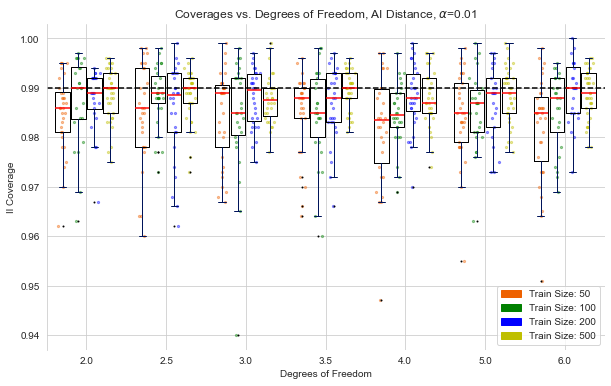

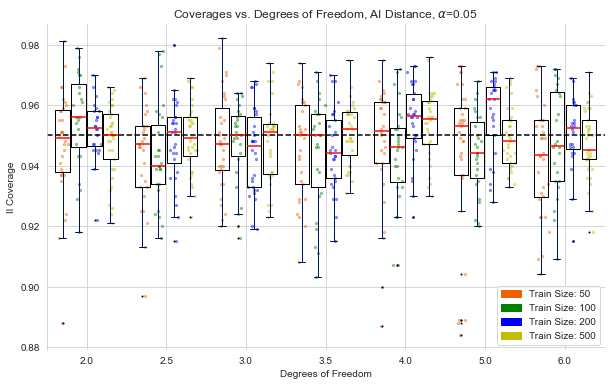

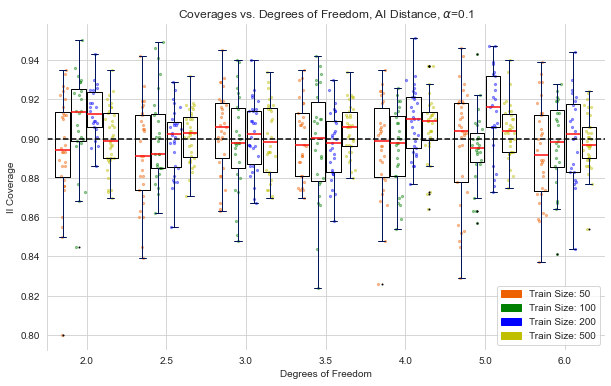

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

for data, alpha_level in zip(
    [coverage_df_AI_alpha_01, coverage_df_AI_alpha_05, coverage_df_AI_alpha_1], 
    [0.01, 0.05, 0.1]):
    if alpha_level == 0.01:
        coverage_df = coverage_df_AI_alpha_01
    elif alpha_level == 0.05:
        coverage_df = coverage_df_AI_alpha_05
    else:
        coverage_df = coverage_df_AI_alpha_1

    # Extract unique train sizes and degrees of freedom
    train_sizes = sorted(coverage_df['train_size'].unique())
    dfs = sorted(coverage_df['df'].unique())

    # Prepare the data for boxplots
    grouped_data = [
        [coverage_df.loc[(coverage_df['df'] == df) & (coverage_df['train_size'] == N), 'II_coverage']
            for N in train_sizes]
        for df in dfs ]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    palette = ['#ee6100', 'g', 'b', 'y']  # Generate unique colors

    for i, group in enumerate(grouped_data):
        #In this loop, select the degrees of freedom
        base_position = 1 + i * (len(train_sizes) + 1)  # spacing between groups

        for j, ts_data in enumerate(group):
            #In this loop, select the train sizes. ts_data is the dataset for a given train size and df
            pos = base_position + j

            #ax.boxplot(ts_data, positions=[pos], widths=1, patch_artist=True, 
            #            boxprops=dict(facecolor=palette[j], alpha=.9),
            #            flierprops={'marker': 'x', 'color': 'red'})
            ax.boxplot(ts_data, positions=[pos], widths = .9, notch=False, whiskerprops=whiskerprops,capprops=capprops, flierprops=flierprops, medianprops=medianprops,showmeans=False) 

    
            palette = ['#ee6100', 'g', 'b', 'y']
            for x, val in zip(np.random.normal(pos, 0.14, ts_data.shape[0]), ts_data):
                ax.scatter(x, val, alpha=0.4, color = palette[j], s = 5)


    sns.despine(bottom=True) # removes right and top axis lines

    # Formatting
    ax.axhline(y = 1 - alpha_level, color='black', linestyle='dashed', label=f'1 - $\\alpha$')
    ax.set_title(f'Coverages vs. Degrees of Freedom, AI Distance, $\\alpha$={alpha_level}')
    ax.set_xticks(
        ticks=[1 + i * (len(train_sizes) + 1) + (len(train_sizes) - 1) / 2 for i in range(len(dfs))],
        labels=dfs
    )
    ax.set_xlim(0, len(dfs) * (len(train_sizes) + 1))
    ax.set_xlabel('Degrees of Freedom')
    ax.set_ylabel('II Coverage')
    legend_handles = [
        mpatches.Patch(color=palette[j], label=f'Train Size: {train_sizes[j]}') 
        for j in range(len(train_sizes))
    ]
    plt.legend(handles=legend_handles, loc='lower right')
    plt.show()

In [29]:
# Note: What is interesting is to see the decaay in the radius as df increases, but 
# comparing the radius between the distances is not informative since the magnitudes depend
# on the distance used

#for data, alpha_level in zip([coverage_df_combined_alpha_01, coverage_df_combined_alpha_05, coverage_df_combined_alpha_1], [0.01, 0.05, 0.1]):   
#    if alpha_level == 0.01:
#        coverage_df = coverage_df_combined_alpha_01
#    elif alpha_level == 0.05:
#        coverage_df = coverage_df_combined_alpha_05
#    else:
#        coverage_df = coverage_df_combined_alpha_1
#
#    coverage_df_LC = coverage_df[coverage_df['distance'] == 'LC']
#    coverage_df_AI = coverage_df[coverage_df['distance'] == 'AI']
#    coverage_df_LE = coverage_df[coverage_df['distance'] == 'LE']
#    
#    plt.figure(figsize=(7,5))
#    sns.boxplot(data=coverage_df_LC, x='df', y='OOB_quantile', hue='train_size', palette=sns.color_palette()[0:4],
#                flierprops={'marker':'x'}, dodge=True)
#    plt.title(f'Prediction ball radius vs. Degrees of freedom, LE distance, $\\alpha=${alpha_level}')
#    plt.ylabel('Radius')
#    plt.xlabel('Degrees of freedom')
#    plt.legend()
#    plt.show()
#
#    plt.figure(figsize=(7,5))
#    sns.boxplot(data=coverage_df_AI, x='df', y='OOB_quantile', hue='train_size', palette=sns.color_palette()[0:4],
#                flierprops={'marker':'x'}, dodge=True)
#    plt.title(f'Prediction ball radius vs. Degrees of freedom, LE distance, $\\alpha=${alpha_level}')
#    plt.ylabel('Radius')
#    plt.xlabel('Degrees of freedom')
#    plt.legend()
#    plt.show()
#
#    plt.figure(figsize=(7,5))
#    sns.boxplot(data=coverage_df_LE, x='df', y='OOB_quantile', hue='train_size', palette=sns.color_palette()[0:4],
#                flierprops={'marker':'x'}, dodge=True)
#    plt.title(f'Prediction ball radius vs. Degrees of freedom, LE distance, $\\alpha=${alpha_level}')
#    plt.ylabel('Radius')
#    plt.xlabel('Degrees of freedom')
#    plt.legend()
#    plt.show()

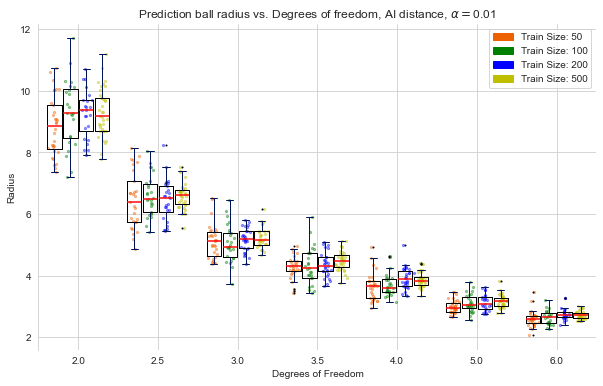

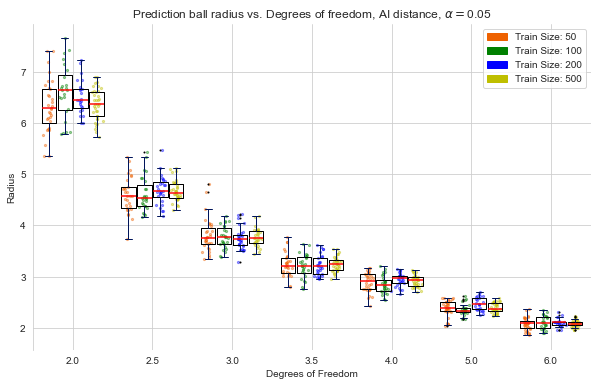

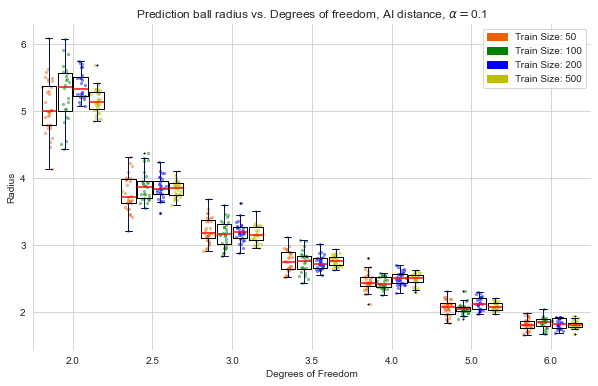

In [30]:
for data, alpha_level in zip(
    [coverage_df_AI_alpha_01, coverage_df_AI_alpha_05, coverage_df_AI_alpha_1], 
    [0.01, 0.05, 0.1]):
    if alpha_level == 0.01:
        coverage_df = coverage_df_AI_alpha_01
    elif alpha_level == 0.05:
        coverage_df = coverage_df_AI_alpha_05
    else:
        coverage_df = coverage_df_AI_alpha_1

    # Extract unique train sizes and degrees of freedom
    train_sizes = sorted(coverage_df['train_size'].unique())
    dfs = sorted(coverage_df['df'].unique())

    # Prepare the data for boxplots
    grouped_data = [
        [coverage_df.loc[(coverage_df['df'] == df) & (coverage_df['train_size'] == N), 'OOB_quantile']
            for N in train_sizes]
        for df in dfs ]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    palette = ['#ee6100', 'g', 'b', 'y']  # Generate unique colors

    for i, group in enumerate(grouped_data):
        #In this loop, select the degrees of freedom
        base_position = 1 + i * (len(train_sizes) + 1)  # spacing between groups

        for j, ts_data in enumerate(group):
            #In this loop, select the train sizes. ts_data is the dataset for a given train size and df
            pos = base_position + j

            #ax.boxplot(ts_data, positions=[pos], widths=1, patch_artist=True, 
            #            boxprops=dict(facecolor=palette[j], alpha=.9),
            #            flierprops={'marker': 'x', 'color': 'red'})
            ax.boxplot(ts_data, positions=[pos], widths = .9, notch=False, whiskerprops=whiskerprops,capprops=capprops, flierprops=flierprops, medianprops=medianprops,showmeans=False) 

    
            palette = ['#ee6100', 'g', 'b', 'y']
            for x, val in zip(np.random.normal(pos, 0.14, ts_data.shape[0]), ts_data):
                ax.scatter(x, val, alpha=0.4, color = palette[j], s = 5)


    sns.despine(bottom=True) # removes right and top axis lines

    # Formatting
    ax.set_title(f'Prediction ball radius vs. Degrees of freedom, AI distance, $\\alpha=${alpha_level}')
    ax.set_xticks(
        ticks=[1 + i * (len(train_sizes) + 1) + (len(train_sizes) - 1) / 2 for i in range(len(dfs))],
        labels=dfs
    )
    ax.set_xlim(0, len(dfs) * (len(train_sizes) + 1))
    ax.set_xlabel('Degrees of Freedom')
    ax.set_ylabel('Radius')
    legend_handles = [
        mpatches.Patch(color=palette[j], label=f'Train Size: {train_sizes[j]}') 
        for j in range(len(train_sizes))
    ]
    plt.legend(handles=legend_handles, loc='upper right')
    plt.show()

# Plot prediction balls

Obtain a smaller dataset with the columns selected conveniently to observe the impact of the parameters in the shape of prediction balls.

In [31]:
# new_coverage_df2 = coverage_df_combined[(coverage_df_combined['sample_index'] == 93) & 
#                               (coverage_df_combined['df'].isin([2])) & 
#                               (coverage_df_combined['train_size'].isin([50, 500]))]
# new_coverage_df2 = new_coverage_df2.sort_values(by=['sample_index', 'train_size', 'df', 'distance']).reset_index(drop=True)
# new_coverage_df2.head()

# Only for AI

new_coverage_df2 = coverage_df_AI[(coverage_df_AI['sample_index'] == 93) & 
                              (coverage_df_AI['df'].isin([2])) & 
                              (coverage_df_AI['train_size'].isin([50, 500]))]
new_coverage_df2 = new_coverage_df2.sort_values(by=['sample_index', 'train_size', 'df', 'distance']).reset_index(drop=True)

new_coverage_df6 = coverage_df_AI[(coverage_df_AI['sample_index'] == 12) & 
                              (coverage_df_AI['df'].isin([6])) & 
                              (coverage_df_AI['train_size'].isin([50, 500]))]
new_coverage_df6 = new_coverage_df6.sort_values(by=['sample_index', 'train_size', 'df', 'distance']).reset_index(drop=True)

new_coverage_df2.head()

new_coverage_df6.head()

,sample_index,train_size,df,y_train_data,train_predictions,OOB_quantile,OOB_errors,forest,distance,II_coverage
0,12,50,6.0,"[[[1.624473324628597, -0.661038523992837], [-0...","[[[1.2773870883582104, -0.785146791594194], [-...","[2.581853042555266, 1.921315219851196, 1.67366...","[1.0971678000406764, 0.2963093703325393, 0.651...","BaggedRegressor(bootstrap_fraction=1, bootstra...",AI,"[0.988, 0.933, 0.872]"
1,12,500,6.0,"[[[1.824217251326454, -1.165610946805374], [-1...","[[[1.017798623190014, -0.5850080939332496], [-...","[2.9588598341856587, 2.034012726794317, 1.7780...","[1.1340471096703928, 0.9389075967443297, 0.661...","BaggedRegressor(bootstrap_fraction=1, bootstra...",AI,"[0.995, 0.936, 0.882]"


In [32]:
# Plot OOB prediction balls
#alpha=0.1
#for ind in [0,5,10]:
#    for row_idx in range(new_coverage_df2.shape[0]):
#        row = new_coverage_df2.loc[row_idx]
#        if row['distance'] == 'AI':
#            M = CustomAffineInvariant(dim=2)
#        elif row['distance'] == 'LC':
#            M = LogCholesky(dim=2)
#        else:
#            M = CustomLogEuclidean(dim=2)
#        oob_errors = row['OOB_errors']
#        test_data = row['y_test_data']
#        test_predictions = row['test_predictions']
#        
#        fig, ax=plt.subplots(figsize=(5, 5))
#        
#        if row['df'] == 2:
#            plt.xlim(-4.5,4.5)
#            plt.ylim(-4.5,4.5)
#            limits_unif = 25
#        else:
#            plt.xlim(-1,1)
#            plt.ylim(-1,1)
#            limits_unif = 5
#        plot_OOB_balls_SPD(dist = row['distance'], predictions = test_predictions, reference=test_data, indices_to_plot= [ind],
#                            Ralpha = row['OOB_quantile'][2], ax=ax, scale_factor=1/2, MC_samples=10000, xy_factor=50, alpha = alpha, limits_unif=limits_unif)
#        ax.set_aspect('equal', 'box')
#
#        plt.title(f'df={int(row["df"])}, N={row["train_size"]}, {row["distance"]} distance, obs {ind}')
#        plt.show()

In [33]:
new_coverage_df6

,sample_index,train_size,df,y_train_data,train_predictions,OOB_quantile,OOB_errors,forest,distance,II_coverage
0,12,50,6.0,"[[[1.624473324628597, -0.661038523992837], [-0...","[[[1.2773870883582104, -0.785146791594194], [-...","[2.581853042555266, 1.921315219851196, 1.67366...","[1.0971678000406764, 0.2963093703325393, 0.651...","BaggedRegressor(bootstrap_fraction=1, bootstra...",AI,"[0.988, 0.933, 0.872]"
1,12,500,6.0,"[[[1.824217251326454, -1.165610946805374], [-1...","[[[1.017798623190014, -0.5850080939332496], [-...","[2.9588598341856587, 2.034012726794317, 1.7780...","[1.1340471096703928, 0.9389075967443297, 0.661...","BaggedRegressor(bootstrap_fraction=1, bootstra...",AI,"[0.995, 0.936, 0.882]"


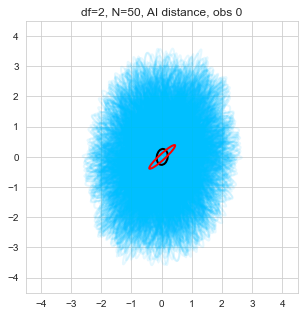

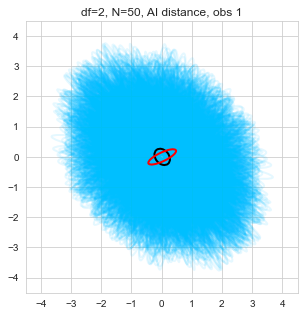

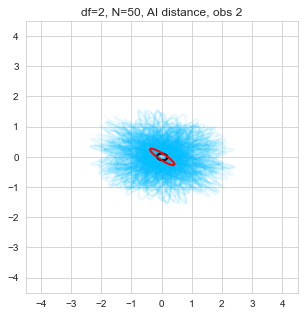

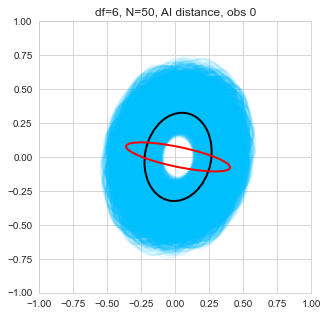

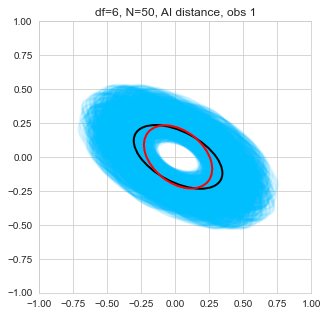

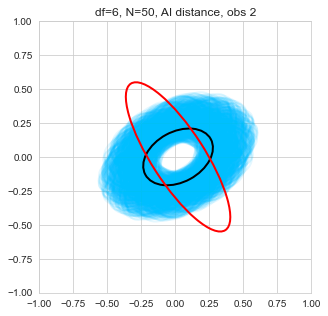

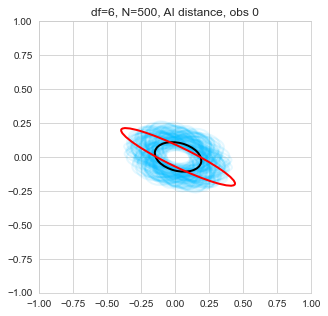

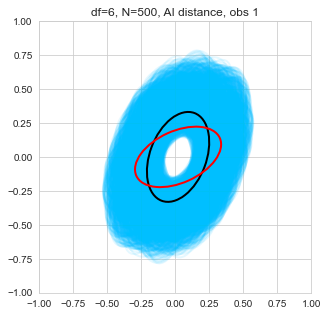

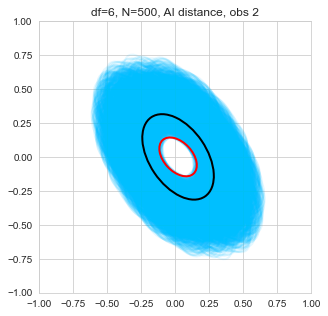

In [34]:
# Plot OOB prediction balls
alpha = 0.1
num_obs = 3

M = CustomLogEuclidean(dim=2)
for dataset in [new_coverage_df2, new_coverage_df6]:
    for row_idx in range(dataset.shape[0]):
        for i in range(num_obs):
            row = dataset.loc[row_idx]
            
            fig, ax=plt.subplots(figsize=(5, 5))
            
            if row['df'] == 2:
                plt.xlim(-4.5,4.5)
                plt.ylim(-4.5,4.5)
                limits_unif = 25
            else:
                plt.xlim(-1,1)
                plt.ylim(-1,1)
                limits_unif = 5
            
            #Generate center of the ball (the point whose prediction uncertainty we want to represent)
            t_center = np.random.uniform(size = 1)
            new_y = sim_regression_matrices( Sigmas = (Sigma_1, Sigma_2, Sigma_3), 
                                                t = t_center,  
                                                df = df)
            
            # Predict the new observation
            new_pred = ln['forest'].predict_matrix(t_center.reshape(-1,1))

            plot_OOB_balls_SPD(dist = row['distance'], reference =new_y['y'][0], prediction = new_pred,
                                Ralpha = row['OOB_quantile'][2], ax=ax, scale_factor=1/2, MC_samples=10000, xy_factor=50, alpha = alpha, limits_unif=limits_unif)
            
            ax.set_aspect('equal', 'box')
            plt.title(f'df={int(row["df"])}, N={row["train_size"]}, {row["distance"]} distance, obs {i}')
            plt.show()